# GPT2 Software optimizations

Here we compare the speed of GPT2 124M with different software optimizations applied.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from gollem.gpu_stats import get_gpu_flops
from gollem.models.gpt2.config import get_gpt2_model_config

model_cfg = get_gpt2_model_config("gpt2")
gpu_name = "H100"


def compute_mfu(tps: float) -> float:
    model_flops_per_token = model_cfg.compute_flops().total / model_cfg.n_ctx
    gpu_flops = get_gpu_flops(gpu_name, "bfloat16")
    return ((model_flops_per_token * tps) / gpu_flops) * 100


/Users/jonathon/code/gollem/gollem/models/gpt2/model.py:18: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## 1. Non-batch size optimizations

We ignore batch size for now and apply other software optimizations including:

- using `bfloat16` instead of `float32`
- using flash attention
- using `torch.compile`
- using the `fused_adamw` optimizer
- using `tensorcores`

In [2]:
# run name: [mean_tps, peak_mem_usage]
non_batch_results = {
    "0_baseline": [27026, 4371],
    "1_bfloat16": [42871, 3514],
    "2_flash_attention": [48154, 2655],
    "3_compile": [55271, 2448],
    "4_fused_adamw": [78750, 2463],
    "5_tensorcores": [79013, 2463],
}
non_batch_df = pd.DataFrame(
    {
        "run_name": list(non_batch_results.keys()),
        "mean_tps": [x[0] for x in non_batch_results.values()],
        "peak_mem_usage": [x[1] for x in non_batch_results.values()],
    }
)

non_batch_df["speedup"] = (
    non_batch_df["mean_tps"]
    / non_batch_df.loc[non_batch_df["run_name"] == "0_baseline", "mean_tps"].values[0]
)
non_batch_df["mfu"] = non_batch_df["mean_tps"].apply(compute_mfu)
non_batch_df["mem_saving"] = (
    non_batch_df["peak_mem_usage"]
    / non_batch_df.loc[
        non_batch_df["run_name"] == "0_baseline", "peak_mem_usage"
    ].values[0]
)

print(non_batch_df)

            run_name  mean_tps  peak_mem_usage   speedup       mfu  mem_saving
0         0_baseline     27026            4371  1.000000  2.334889    1.000000
1         1_bfloat16     42871            3514  1.586287  3.703805    0.803935
2  2_flash_attention     48154            2655  1.781766  4.160225    0.607412
3          3_compile     55271            2448  2.045105  4.775092    0.560055
4      4_fused_adamw     78750            2463  2.913861  6.803541    0.563487
5      5_tensorcores     79013            2463  2.923592  6.826263    0.563487


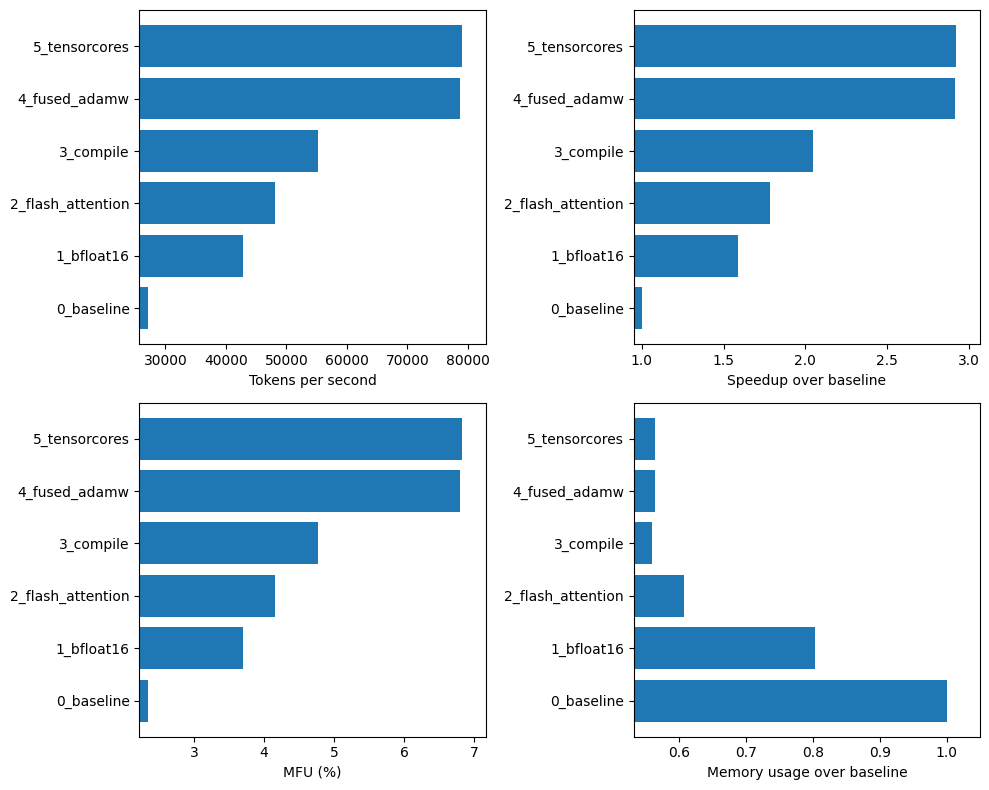

In [16]:
# Mean TPS
n_rows = len(non_batch_df)
fig_height = max(4, n_rows * 0.2)

fig, axs = plt.subplots(2, 2, figsize=(10, fig_height * 2))

y_labels = {
    "mean_tps": "Tokens per second",
    "speedup": "Speedup over baseline",
    "mfu": "MFU (%)",
    "mem_saving": "Memory usage over baseline",
}

for i, (ax, col) in enumerate(
    zip(axs.flatten(), ["mean_tps", "speedup", "mfu", "mem_saving"])
):
    ax.barh(non_batch_df["run_name"], non_batch_df[col])
    ax.set_xlabel(y_labels[col])
    # ax.set_ylabel("Optimization")
    ax.set_xlim(min(non_batch_df[col]) * 0.95, max(non_batch_df[col]) * 1.05)

plt.tight_layout()
plt.show()
# ax = non_batch_df.plot(
#     x="run_name", y="mean_tps", kind="barh", figsize=(4, fig_height), legend=False
# )
# ax.set_xlabel("Tokens per second")
# ax.set_ylabel("Optimization")
# ax.set_xlim(min(non_batch_df["mean_tps"]) * 0.95, max(non_batch_df["mean_tps"]) * 1.05)

## 2. Increasing batch size

Using all of the optimizations from the previous section, here we increase the batch size until we hit the memory limit of the GPU, and see how that affects throughput.
